# Single-Cell RNA-seq Analysis of Lung Adenocarcinoma (LUAD)

This notebook contains an analysis of single-cell RNA sequencing data from lung adenocarcinoma (LUAD) samples and adjacent normal tissue. The dataset was sourced from ArrayExpress ([E-MTAB-13526](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-13526)).

There are 12 patiens with lung adenocarcinoma: 'P5' 'P6' 'P7' 'P9' 'P10' 'P13' 'P14' 'P15' 'P16' 'P21' 'P22' 'P24', but we will use data from patients P9 and P14.

## Download the data

Open the Windows Command Prompt in `/data` folder and run the following command:
`ftp -i -s:.\win.txt`

Alternatively, use Linux ternimal and run: `cat ./unix.txt | sh`

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from matplotlib.backends.backend_pdf import PdfPages


data_path = "./data/"
metadata_path = "./data/E-MTAB-13526.sdrf.txt"
graphics_path = "./graphics"

os.makedirs(f"{graphics_path}/QC", exist_ok=True)

In [6]:
samples = set([file.split("-")[0] for file in os.listdir(data_path) if file.endswith("matrix.mtx.gz")])
print(samples)

# Subset 6 patients
pattern = re.compile(r'^(P5|P6|P7|P9|P10|P13)_')
samples = {entry for entry in samples if pattern.match(entry)}
print(samples)

{'D2_1', 'D2_4', 'D2_3', 'P24_T2', 'P22_B1', 'P12_B1', 'P7_T1', 'P12_T1', 'P21_B3', 'P13_B1', 'P15_B1', 'P24_B1', 'P16_B2', 'P23_T2', 'D1_2', 'P15_T1', 'P21_B2', 'P10_B1', 'D1_1', 'P5_B1', 'P10_T1', 'P21_T2', 'P14_B1', 'P23_B1', 'P22_B2', 'P16_T2', 'P21_B1', 'D2_2', 'P23_T1', 'P7_B1', 'P9_B1', 'P22_T2', 'P6_B1', 'P5_T1', 'P16_B1', 'P21_T1', 'P14_T1', 'P16_T1', 'P24_T1', 'P23_B2', 'P9_T1', 'P22_T1', 'P15_B2', 'P24_B2', 'P13_T1', 'P15_T2', 'P6_T1'}
{'P7_B1', 'P9_B1', 'P6_B1', 'P5_T1', 'P10_B1', 'P13_B1', 'P5_B1', 'P7_T1', 'P10_T1', 'P13_T1', 'P6_T1', 'P9_T1'}


In [7]:
adata_list = []

print("----------------------------------------------------")
print("DATA READING".center(52,"-"))
print("----------------------------------------------------\n")
print(f"Processing {len(samples)} samples: {samples}\n")

for sample in samples:
    
    print(f"Processing {sample} sample...")
    
    adata = sc.read_10x_mtx(data_path, var_names="gene_symbols", cache=True, prefix=f"{sample}-")

    adata.var_names_make_unique()
    adata.obs["sample"] = sample
    sc.pp.filter_cells(adata, min_counts=30)
    sc.pp.filter_cells(adata, min_genes=10)

    # Sample 200,000 cells from each sample
    #if adata.n_obs > 200000:
    #    adata = sc.pp.sample(adata, n=200000, copy=True)
    
    adata_list.append(adata)

print("Combining datasets...")
adata_combined = adata_list[0].concatenate(adata_list[1:], batch_key='sample', batch_categories=samples)

adata_combined.obs['sample'] = adata_combined.obs['sample'].astype(str)

print("Data combined successfully!")
print(adata_combined)

# Save the object
adata_combined.write(os.path.join(data_path, "adata_combined.h5ad"))

----------------------------------------------------
--------------------DATA READING--------------------
----------------------------------------------------

Processing 12 samples: {'P7_B1', 'P9_B1', 'P6_B1', 'P5_T1', 'P10_B1', 'P13_B1', 'P5_B1', 'P7_T1', 'P10_T1', 'P13_T1', 'P6_T1', 'P9_T1'}

Processing P7_B1 sample...
Processing P9_B1 sample...
Processing P6_B1 sample...
Processing P5_T1 sample...
Processing P10_B1 sample...
Processing P13_B1 sample...
Processing P5_B1 sample...
Processing P7_T1 sample...
Processing P10_T1 sample...
Processing P13_T1 sample...
Processing P6_T1 sample...
Processing P9_T1 sample...
Combining datasets...


/tmp/ipykernel_5052/2151177085.py:26: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_list[0].concatenate(adata_list[1:], batch_key='sample', batch_categories=samples)


Data combined successfully!
AnnData object with n_obs × n_vars = 310688 × 33538
    obs: 'sample', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'


In [29]:
# Read the object
#adata_combined = sc.read_h5ad(os.path.join(data_path, "adata_combined_P9P14.h5ad"))

In [8]:
adata_combined

AnnData object with n_obs × n_vars = 310688 × 33538
    obs: 'sample', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'

## Add metadata

We will add Patient ID, Age, sampling site (tumor or normal tissue), sex and cancer stage from metadata.

In [9]:
metadata = pd.read_csv(metadata_path, sep="\t")
metadata = metadata.drop_duplicates(subset="Source Name")

metadata = metadata[metadata["Factor Value[disease]"] == "lung adenocarcinoma"]
metadata.rename(
    columns={
        "Characteristics[individual]": "Patient",
        "Characteristics[age]": "Age",
        "Factor Value[sampling site]": "Sampling site",
        "Characteristics[sex]": "Sex",
        "Characteristics[tumor grading]": "Cancer stage"
    },
    inplace=True
)

infos = ["Patient","Age","Sampling site","Sex","Cancer stage"]
for info in infos:
    adata_combined.obs[info] = adata_combined.obs["sample"].map(metadata.set_index("Source Name")[info])

print(adata_combined.obs['sample'].unique())
print(adata_combined.obs.head())

['P7_B1', 'P9_B1', 'P6_B1', 'P5_T1', 'P10_B1', ..., 'P7_T1', 'P10_T1', 'P13_T1', 'P6_T1', 'P9_T1']
Length: 12
Categories (12, object): ['P5_B1', 'P5_T1', 'P6_B1', 'P6_T1', ..., 'P10_B1', 'P10_T1', 'P13_B1', 'P13_T1']
                         sample  n_counts  n_genes    Patient  Age  \
AAACCCAAGGCGACAT-1-P7_B1  P7_B1     166.0      125  Patient 7   58   
AAACCCAAGTAGGGTC-1-P7_B1  P7_B1   17318.0     3965  Patient 7   58   
AAACCCACAATGGGTG-1-P7_B1  P7_B1      37.0       29  Patient 7   58   
AAACCCACACAATCTG-1-P7_B1  P7_B1     289.0      204  Patient 7   58   
AAACCCACATAGGTTC-1-P7_B1  P7_B1      41.0       32  Patient 7   58   

                                            Sampling site   Sex Cancer stage  
AAACCCAAGGCGACAT-1-P7_B1  normal tissue adjacent to tumor  male      T1cN0M0  
AAACCCAAGTAGGGTC-1-P7_B1  normal tissue adjacent to tumor  male      T1cN0M0  
AAACCCACAATGGGTG-1-P7_B1  normal tissue adjacent to tumor  male      T1cN0M0  
AAACCCACACAATCTG-1-P7_B1  normal tissue adjace

## QC metrics

The first step in quality control is to remove low-quality cells from the dataset. When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell. As these cells are usually not the main target of our analysis and might distort our downstream analysis, we are removing them during quality control. For identifying them, we define cell quality control (QC) threshold. Cell QC is typically performed on the following three QC covariates:

The number of counts per barcode (count depth)

The number of genes per barcode

The fraction of counts from mitochondrial genes per barcode

In [10]:
# mitochondrial genes
adata_combined.var["mt"] = adata_combined.var_names.str.startswith("MT-")
# ribosomal genes
adata_combined.var["ribo"] = adata_combined.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_combined.var["hb"] = adata_combined.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata_combined, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [ ]:
samples = adata_combined.obs["sample"].unique()

cols = 2
rows = int(np.ceil(len(samples) / cols))

sample_subsets = {sample: adata_combined[adata_combined.obs["sample"] == sample] for sample in samples}

# Distribution of n_genes_by_counts
output_path = os.path.join(graphics_path, "QC", "n_genes_by_counts_distribution_before_QC.pdf")

with PdfPages(output_path) as pdf:
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5), squeeze=False)
    for idx, sample in enumerate(samples):
        subset = sample_subsets[sample]
        max_genes = subset.obs['n_genes_by_counts'].max()
        sns.histplot(subset.obs['n_genes_by_counts'], bins=100, kde=False, ax=axs[idx // cols][idx % cols], color="black")
        axs[idx // cols][idx % cols].set_xlim(0, max_genes if max_genes < 2000 else 2000)
        axs[idx // cols][idx % cols].set_title(f"{sample} - Genes per Cell")
        axs[idx // cols][idx % cols].set_xlabel("Number of Genes")
        axs[idx // cols][idx % cols].set_ylabel("Cell Count")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)


# Distribution of total_counts
output_path = os.path.join(graphics_path, "QC", "total_counts_distribution_before_QC.pdf")

with PdfPages(output_path) as pdf:
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5), squeeze=False)
    for idx, sample in enumerate(samples):
        subset = sample_subsets[sample]
        max_counts = subset.obs['total_counts'].max()
        sns.histplot(subset.obs['total_counts'], bins=100, kde=False, ax=axs[idx // cols][idx % cols], color="black")
        axs[idx // cols][idx % cols].set_xlim(0, max_counts if max_counts < 5000 else 5000)
        axs[idx // cols][idx % cols].set_title(f"{sample} - Total Counts per Cell")
        axs[idx // cols][idx % cols].set_xlabel("Total Counts")
        axs[idx // cols][idx % cols].set_ylabel("Cell Count")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

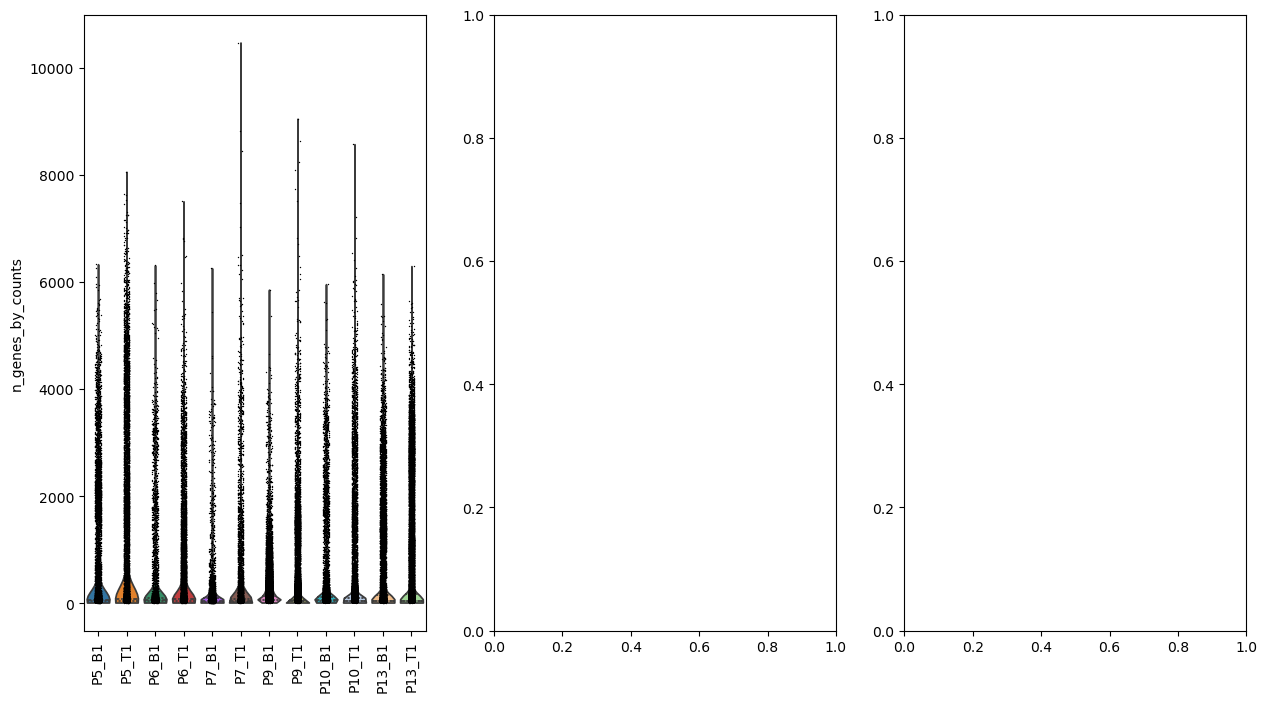

<Figure size 640x480 with 0 Axes>

In [ ]:
# Violin Plots for QC Metrics

qc_metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

output_path = os.path.join(graphics_path, "QC", "violin_plots_before_QC.pdf")

with PdfPages(output_path) as pdf:
    fig, axs = plt.subplots(1, len(qc_metrics), figsize=(5 * len(qc_metrics), 8))
    for idx, metric in enumerate(qc_metrics): 
        sc.pl.violin(
        adata_combined,
        keys=metric,
        groupby="sample",
        ax=axs[idx],
        rotation=90,
        show=True,
        inner='quartile')
        axs[idx].set_title(f"Distribution of {metric}")
        axs[idx].set_xlabel("Samples")
        axs[idx].set_ylabel(metric.replace("_", " ").capitalize())
        axs[idx].yaxis.set_label_coords(-0.151, 0.5)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

Cells: 310688, Genes: 33538
Remaining cells: 47542, Remaining genes: 33538


/tmp/ipykernel_5052/4086703314.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['percent_mito'] = np.sum(


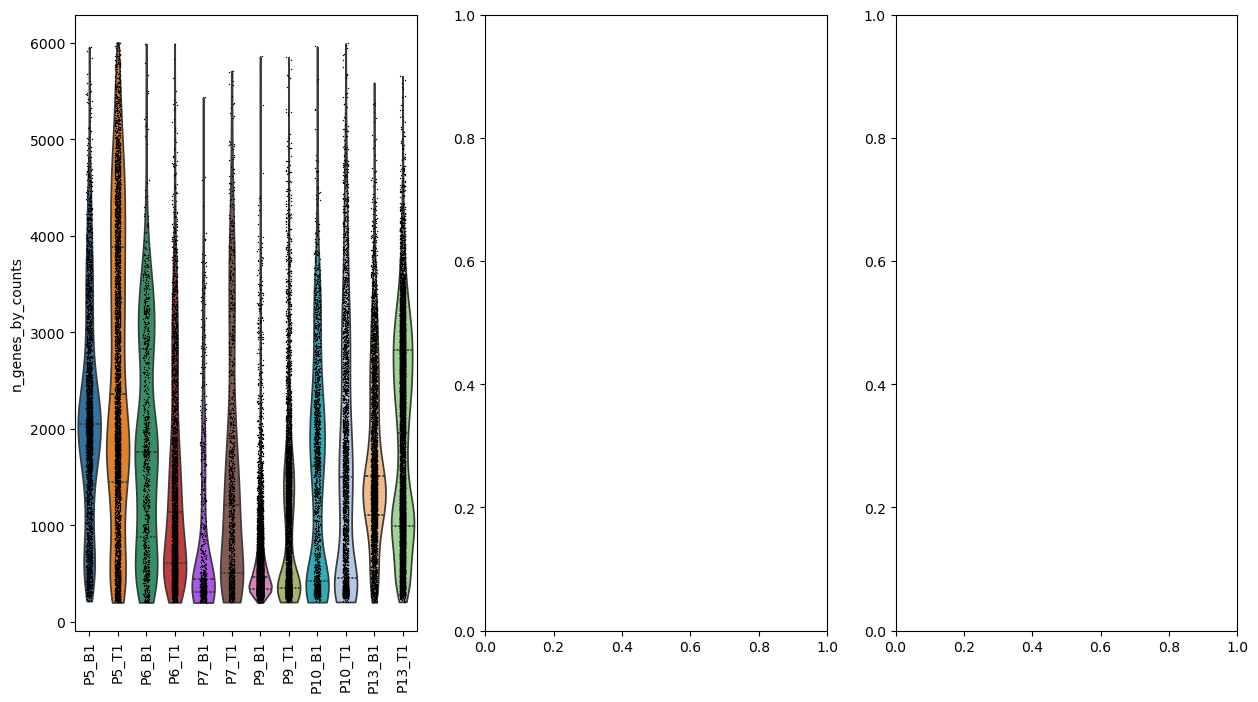

<Figure size 640x480 with 0 Axes>

In [16]:
min_genes = 200
max_genes = 6000
min_counts = 400
max_counts = 100000
max_pctMito = 20

adata_filtered = adata_combined[
    (adata_combined.obs["n_genes_by_counts"] >= min_genes) &
    (adata_combined.obs["n_genes_by_counts"] <= max_genes) &
    (adata_combined.obs["total_counts"] >= min_counts) &
    (adata_combined.obs["total_counts"] <= max_counts) &
    (adata_combined.obs["pct_counts_mt"] <= max_pctMito)
]

print(f"Cells: {adata_combined.n_obs}, Genes: {adata_combined.n_vars}")
print(f"Remaining cells: {adata_filtered.n_obs}, Remaining genes: {adata_filtered.n_vars}")

adata_filtered.write(os.path.join(data_path, "adata_filtered.h5ad"))

mito_genes = adata_filtered.var_names.str.startswith('MT-')
adata_filtered.obs['percent_mito'] = np.sum(
    adata_filtered[:, mito_genes].X, axis=1).A1 / np.sum(adata_filtered.X, axis=1).A1

samples = adata_filtered.obs["sample"].unique()

output_path = os.path.join(graphics_path, "QC", "violin_plots_after_QC.pdf")

with PdfPages(output_path) as pdf:
    fig, axs = plt.subplots(1, len(qc_metrics), figsize=(5 * len(qc_metrics), 8))
    for idx, metric in enumerate(qc_metrics): 
        sc.pl.violin(
        adata_filtered,
        keys=metric,
        groupby="sample",
        ax=axs[idx],
        rotation=90,
        show=True,
        inner='quartile')
        axs[idx].set_title(f"Distribution of {metric}")
        axs[idx].set_xlabel("Samples")
        axs[idx].set_ylabel(metric.replace("_", " ").capitalize())
        axs[idx].yaxis.set_label_coords(-0.151, 0.5)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)


In [17]:
adata_filtered

AnnData object with n_obs × n_vars = 47542 × 33538
    obs: 'sample', 'n_counts', 'n_genes', 'Patient', 'Age', 'Sampling site', 'Sex', 'Cancer stage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

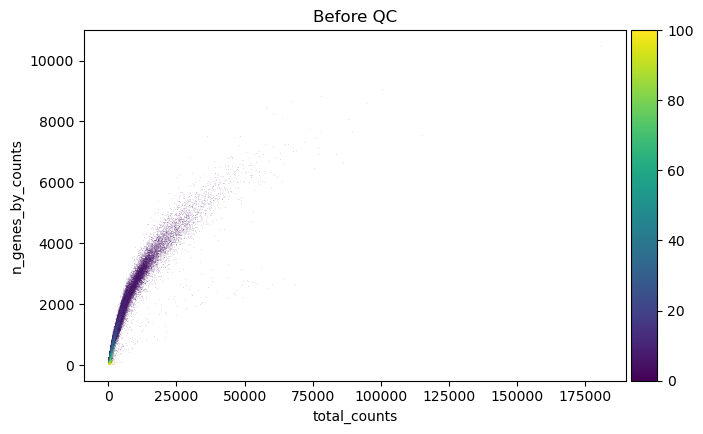

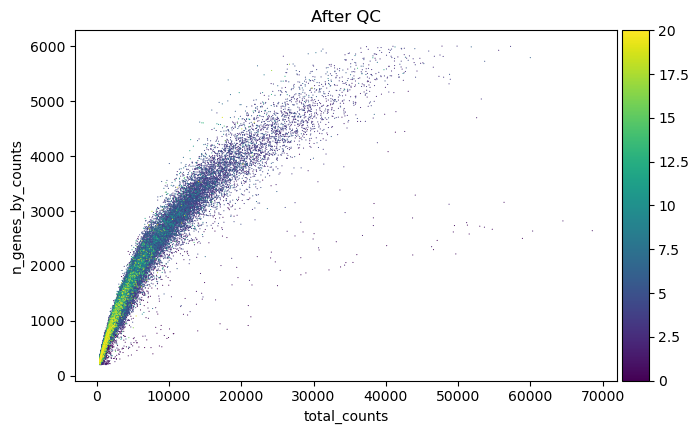

In [15]:
sc.pl.scatter(
    adata_combined,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    title = "Before QC"
)

sc.pl.scatter(
    adata_filtered,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    title = "After QC"
)

Number of predicted doublets: 
 predicted_doublet
False    47490
True        52
Name: count, dtype: int64


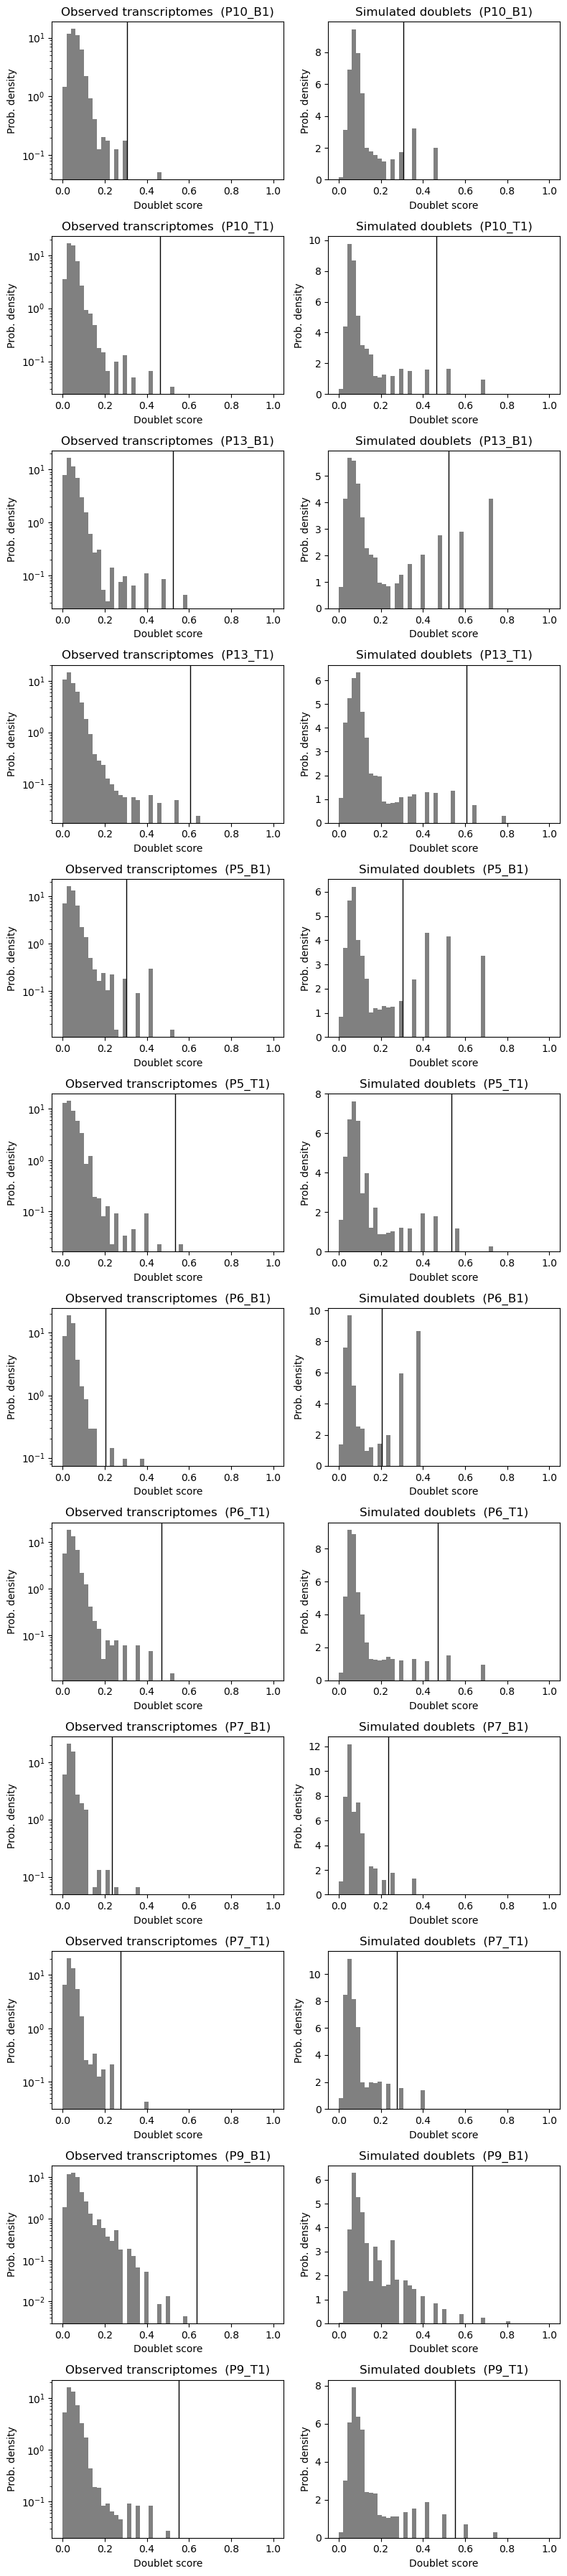

<Figure size 640x480 with 0 Axes>

In [18]:
sc.pp.scrublet(adata_filtered, batch_key="sample")
print(f"Number of predicted doublets: \n {adata_filtered.obs["predicted_doublet"].value_counts()}")
sc.pl.scrublet_score_distribution(adata_filtered)
plt.savefig(os.path.join(graphics_path, "QC", "doublets_prediction.pdf"))

## Normalization

The goal here is to standardize the data for comparisons across cells by normalizing counts and applying a log transformation.

In [19]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_filtered)
# Logarithmize the data
sc.pp.log1p(adata_filtered)

Feature selection

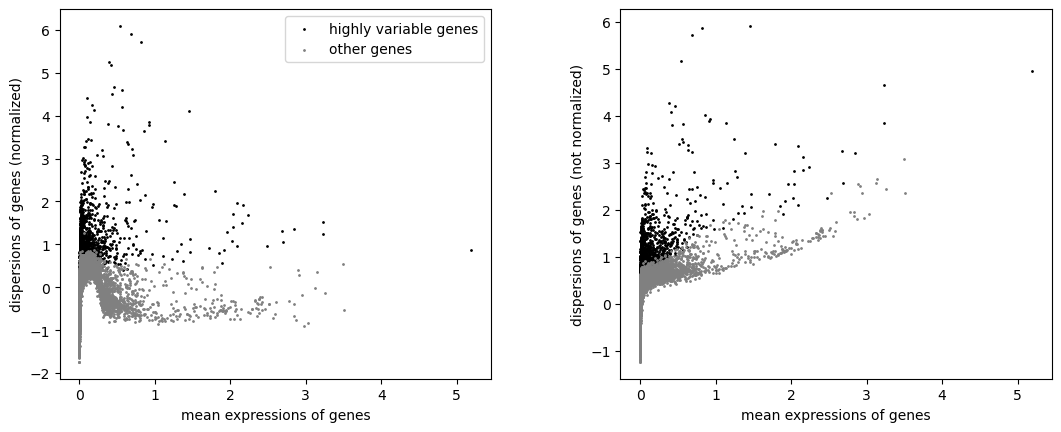

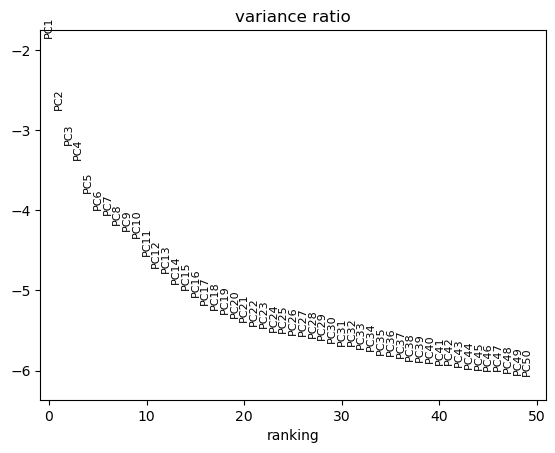

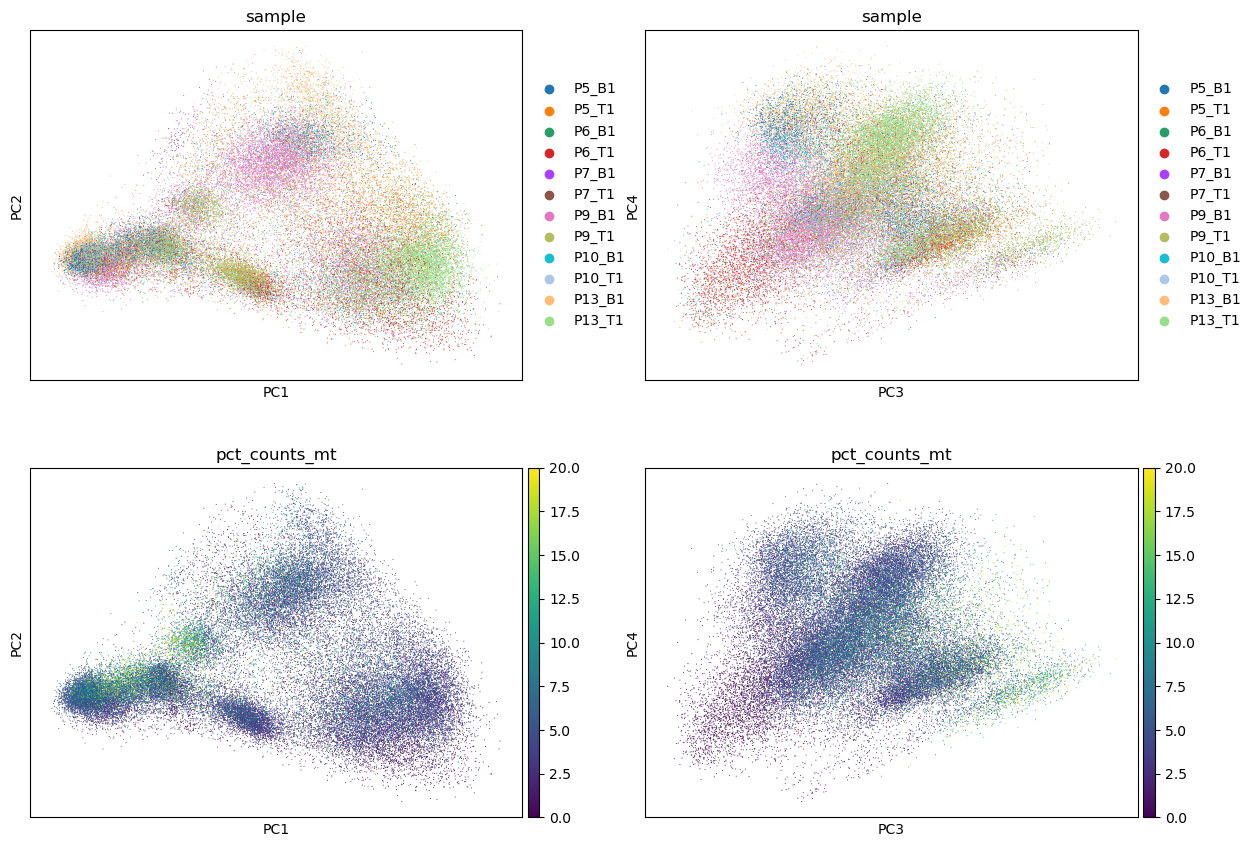

In [20]:
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata_filtered)

sc.tl.pca(adata_filtered)
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=50, log=True)
sc.pl.pca(
    adata_filtered,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

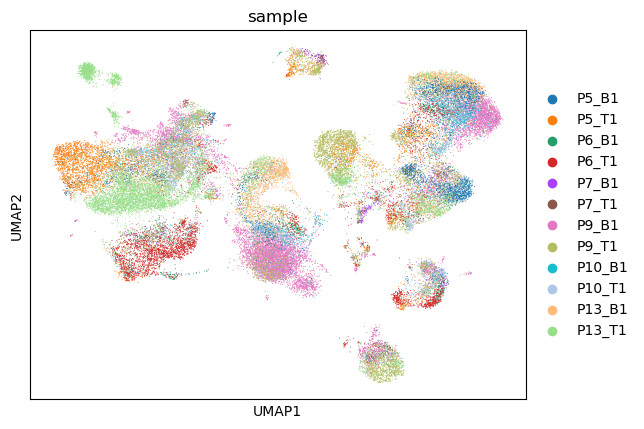

In [21]:
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)
sc.pl.umap(
    adata_filtered,
    color="sample",
    size=2)

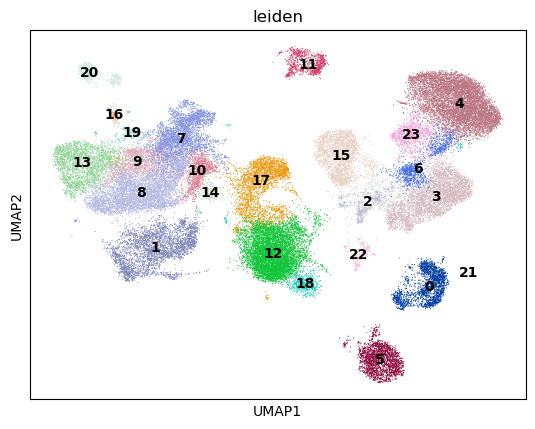

<Figure size 640x480 with 0 Axes>

In [ ]:
sc.tl.leiden(adata_filtered, flavor="igraph", resolution=1.5)

output_path = os.path.join(graphics_path, "QC", "umap_clusters.pdf")

with PdfPages(output_path) as pdf:
    fig, ax = plt.subplots()
    sc.pl.umap(adata_filtered, color=["leiden"], legend_loc="on data", ax=ax, show=True)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)  

Find cluster marker genes

/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/vera/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:434: Performanc

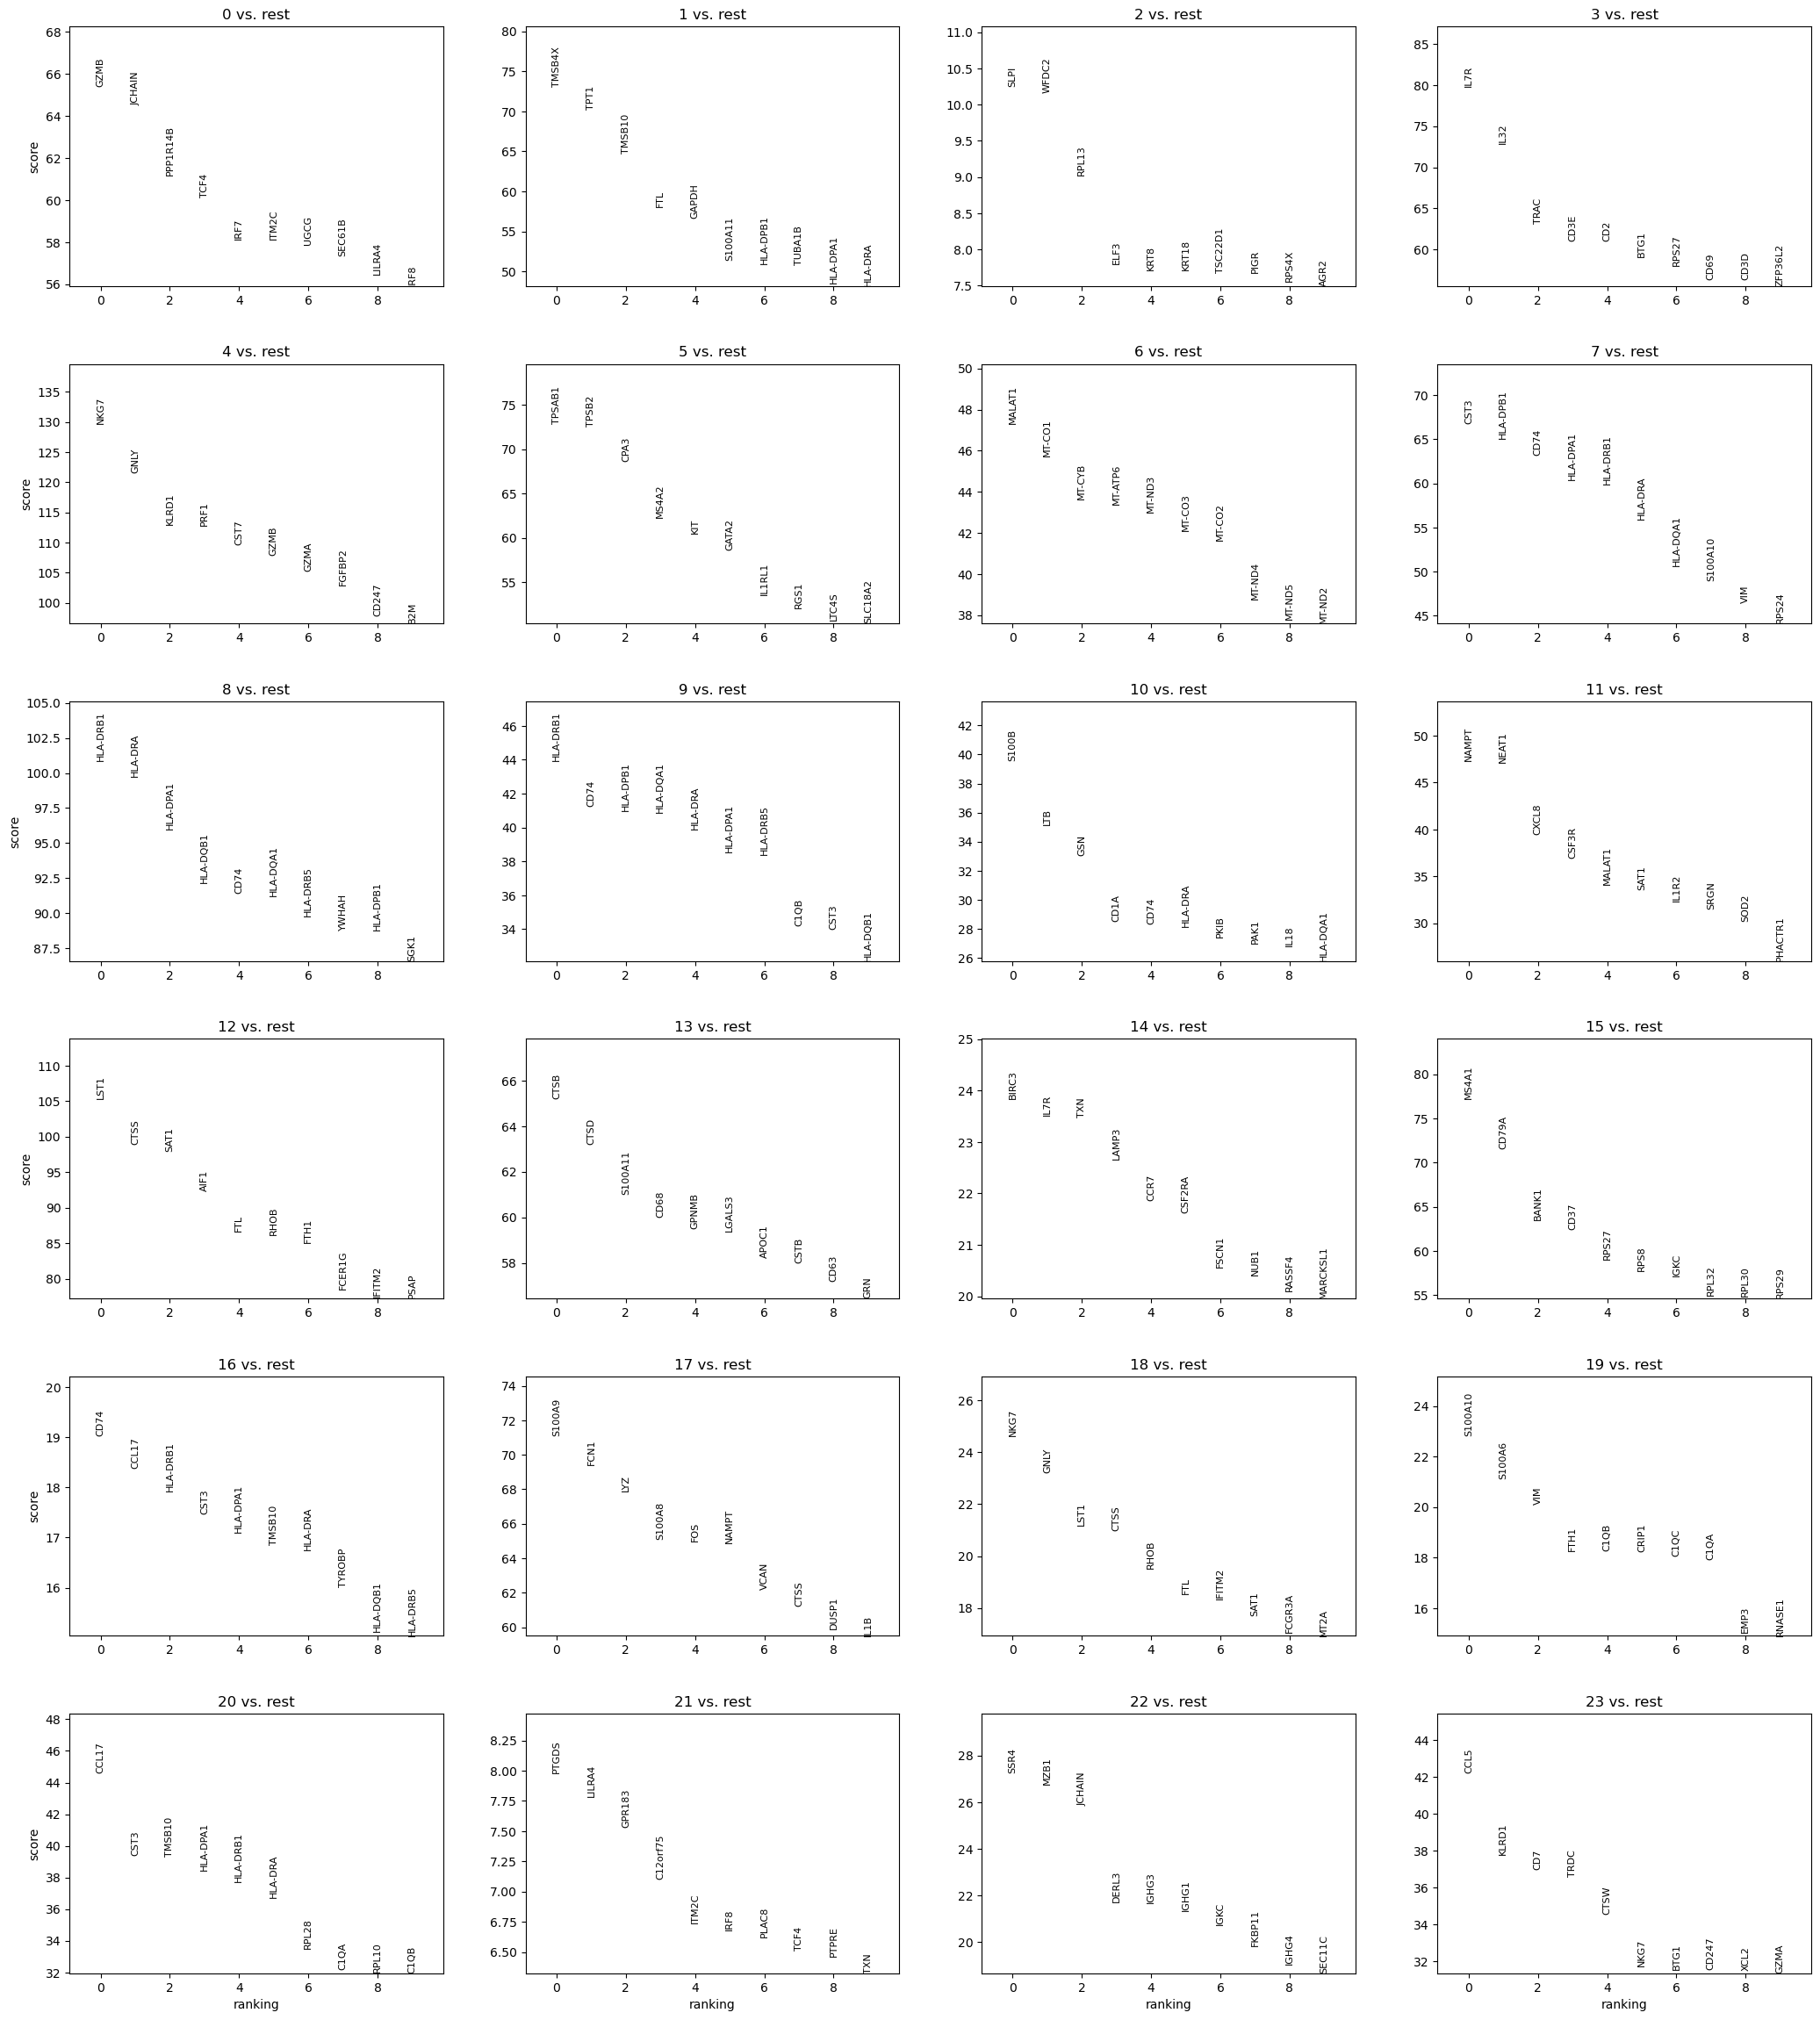

In [23]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_filtered, n_genes=10, sharey=False)

In [24]:
adata_filtered.write(os.path.join(data_path, "adata_filtered.h5ad"))